# Cluster Optimisation

> Optimise points in 3d space based on a potential

In [ ]:
#| default_exp clusters

In [ ]:
#| export
#| echo: false
import numbers
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import basinhopping
import sympy as sp

In [ ]:
#| export
def _unitv(r):
    """returns unit vector in the direction of r"""
    return(r/np.linalg.norm(r))
def _dist(v1,v2):
    """returns the magnitude of the distance between two vectors"""
    return np.linalg.norm(v1-v2)
def _vector_sum(*vectors):
    """sums vectors"""
    array = np.array([*vectors])
    return np.sum(array, axis = 0)
def _fun_gen(f: 'str'):
    """converts a function of r, written as a string into a python function, and a function for its derivative"""
    r = sp.Symbol('r')
    y = sp.sympify(f)
    yprime = y.diff(r)
    f = sp.lambdify(r, y, 'numpy')
    fprime = sp.lambdify(r, yprime, 'numpy')
    if not isinstance(2*f(2.2), numbers.Number):
        raise ValueError('Please enter a function purely of "r"')
    return f, fprime
def _calc_setup(function: 'str'):
    """converts pairwise energies and forces, to total energy and net force on each point"""
    U, dU = _fun_gen(function)
    def E_calc(points):
        """The sum of the pairwise energies"""
        points = points.reshape(-1,3)
        E=0
        for i,v in enumerate(points):
            for w in points[i+1:]:
                r = _dist(v,w)
                E = E + U(r)
        return E
    def F_calc(points):
        """The net forces acting on each point"""
        points = points.reshape(-1,3)
        forces = np.zeros(points.shape)
        for i,v in enumerate(points):
            for j,w in enumerate(points[i+1:]):
                forces[i] = forces[i]+dU(_dist(v,w))*_unitv(w-v)
                forces[j+i+1] = forces[j+i+1]+dU(_dist(v,w))*_unitv(v-w)
        return forces
    return E_calc, F_calc

In [ ]:
#| export
def CoM(*vectors):
    """returns the CoM of vectors"""
    return _vector_sum(*vectors)/len(vectors)

In [ ]:
#| export
def CoMTransform(*vectors):
    """Transforms vectors so the CoM is at the origin"""
    com = CoM(*vectors)
    return np.array([*vectors])-com

In [ ]:
#| export
def InertiaTensor(*vectors):
    """returns the inertia tensor of 3D vectors"""
    Ixx = 0
    Iyy = 0
    Izz = 0
    Ixy = 0
    Iyz = 0
    Ixz = 0
    for vector in vectors:
        Ixx = Ixx + vector[1]**2 + vector[2]**2
        Iyy = Iyy + vector[0]**2 + vector[2]**2
        Izz = Izz + vector[0]**2 + vector[1]**2
        Ixy = Ixy - vector[0]*vector[1]
        Iyz = Iyz - vector[1]*vector[2]
        Ixz = Ixz - vector[0]*vector[2]
    return np.matrix([[Ixx, Ixy, Ixz], [Ixy, Iyy, Iyz], [Ixz, Iyz, Izz]])

In [ ]:
#| export
def point_setup(n:'int', seed:'int'=0):
    """returns n points distributed on the unit sphere"""
    np.random.seed(seed)
    points = np.random.randn(3, n)
    points /= np.linalg.norm(points, axis=0)
    points = points.transpose()
    return np.array(points)

In [ ]:
#| export
def geom_opt(points, F_calc, iterations = 1000, factor = 1e-4):
    """optimises geometry of points in 3D space using gradient descent"""
    for _ in range(iterations):
        forces = F_calc(points)
        points = points + factor*forces
    return points

In [ ]:
#| export
class System:
    def __init__(self, n:"int"=7, function:"str"='(4*((1/r)**12 -(1/r)**6))'):
        self.n = n
        self.U, self.F = _calc_setup(function)
        self.points = point_setup(n)
        self.E = self.U(self.points)
    def plot(self):
        x, y, z = self.points.transpose()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, c= 'blue', alpha=1)
        ax.axes.set_xlim3d(left=-1.2, right=1.2)
        ax.axes.set_ylim3d(-1.2, 1.2)
        ax.axes.set_zlim3d(-1.2, 1.2)
        ax.set_box_aspect([1,1,1])
        plt.show()
    def optimise(self, riter:'int'=10000, giter:'int'=1000, gfactor:'int'=1e-4, biter:'int'=100):
        for i in range(riter):
            x = point_setup(self.n,i)
            E = self.U(x)
            if E<self.E:
                self.points = x
                self.E = E
        self.points = geom_opt(self.points, self.F, iterations=giter, factor = gfactor)
        self.points = CoMTransform(*self.points)
        self.E = self.U(self.points)
        minimizer_kwargs = {"method": "BFGS"}
        res = basinhopping(self.U, self.points.flatten(), minimizer_kwargs=minimizer_kwargs,
                        niter=biter)
        self.points = res.x.reshape(-1,3)
        self.points = np.array(CoMTransform(*self.points))
        self.E = res.fun
    def __str__(self):
        return ("Energy %.6f, for %d points" % (self.E, self.n))
    def xyz(self, name = None):
        if name is None:
            print(self.n)
            print("Energy %.6f, for %d points, calculated by ChemII tools" % (self.E, self.n))
            for v in self.points:
                print("He %.10f %.10f %.10f" % (v[0], v[1], v[2]))
        else:
            with open(name,"w+", encoding="utf-8") as f:
                f.write("%d\n" % (self.n))
                f.write("Energy %.6f, for %d points, calculated by ChemII tools\n" % (self.E, self.n))
                for v in self.points:
                    f.write("He %.10f %.10f %.10f\n" % (v[0], v[1], v[2]))
    def CoM(self):
        return CoM(*self.points)
    def InertiaTensor(self):
        return InertiaTensor(*self.points)

In [ ]:
lj7 = System(7, '(4*((1/r)**12 -(1/r)**6))')
lj7.optimise()

In [ ]:
print(lj7)

Energy -16.505384, for 7 points


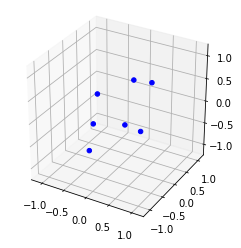

In [ ]:
lj7.plot()

In [ ]:
m7 = System(5, '(1-exp(-(r-1)))**2')
m7.optimise()

In [ ]:
print(m7)

Energy 0.147672, for 5 points


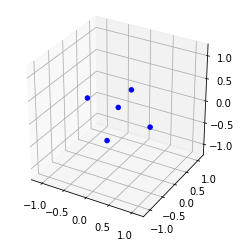

In [ ]:
m7.plot()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()